[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/flax/blob/main/docs_nnx/mnist_tutorial.ipynb)
[![Open On GitHub](https://img.shields.io/badge/Open-on%20GitHub-blue?logo=GitHub)](https://github.com/google/flax/blob/main/docs_nnx/mnist_tutorial.ipynb)

# MNIST tutorial

Welcome to Flax NNX! In this tutorial you will learn how to build and train a simple convolutional neural network (CNN) to classify handwritten digits on the MNIST dataset using the Flax NNX API.

Flax NNX is a Python neural network library built upon [JAX](https://github.com/jax-ml/jax). If you have used the Flax Linen API before, check out [Why Flax NNX](https://flax.readthedocs.io/en/latest/why.html). You should have some knowledge of the main concepts of deep learning.

Let’s get started!

## 1. Install Flax

If `flax` is not installed in your Python environment, use `pip` to install the package from PyPI (below, just uncomment the code in the cell if you are working from Google Colab/Jupyter Notebook):

In [ ]:
# !pip install flax

## 2. Load the MNIST dataset

First, you need to load the MNIST dataset and then prepare the training and testing sets via Tensorflow Datasets (TFDS). You normalize image values, shuffle the data and divide it into batches, and prefetch samples to enhance performance.

In [1]:
import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.

tf.random.set_seed(0)  # Set the random seed for reproducibility.

train_steps = 1200
eval_every = 200
batch_size = 32

train_ds: tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # Normalize train set

test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # Normalize the test set

# Create a shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from.
train_ds = train_ds.repeat().shuffle(1024)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.NYNPAM_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.NYNPAM_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## 3. Define the model with Flax NNX

Create a CNN for classification with Flax NNX by subclassing `nnx.Module`:

In [2]:
from flax import nnx  # The Flax NNX API.
from functools import partial

class CNN(nnx.Module):
  """A simple CNN model."""

  def __init__(self, *, rngs: nnx.Rngs):
    self.conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), rngs=rngs)
    self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), rngs=rngs)
    self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
    self.linear1 = nnx.Linear(3136, 256, rngs=rngs)
    self.linear2 = nnx.Linear(256, 10, rngs=rngs)

  def __call__(self, x):
    x = self.avg_pool(nnx.relu(self.conv1(x)))
    x = self.avg_pool(nnx.relu(self.conv2(x)))
    x = x.reshape(x.shape[0], -1)  # flatten
    x = nnx.relu(self.linear1(x))
    x = self.linear2(x)
    return x

# Instantiate the model.
model = CNN(rngs=nnx.Rngs(0))
# Visualize it.
nnx.display(model)

### Run the model

Let's put the CNN model to the test!  Here, you’ll perform a forward pass with arbitrary data and print the results.

In [3]:
import jax.numpy as jnp  # JAX NumPy

y = model(jnp.ones((1, 28, 28, 1)))
y

Array([[ 0.18405598,  0.50485927,  0.2009596 ,  0.4873969 , -0.37915212,
        -0.5551914 , -0.54481304, -0.04560151,  0.05879337,  0.13339703]],      dtype=float32)

## 4. Create the optimizer and define some metrics

In Flax NNX, you need to create an `nnx.Optimizer` object to manage the model's parameters and apply gradients during training. `nnx.Optimizer` receives the model's reference, so that it can update its parameters, and an [Optax](https://optax.readthedocs.io/) optimizer to define the update rules. Additionally, you will define an `nnx.MultiMetric` object to keep track of the `Accuracy` and the `Average` loss.

In [4]:
import optax

learning_rate = 0.005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

## 5. Define training step functions

In this section, you will define a loss function using the cross entropy loss ([`optax.softmax_cross_entropy_with_integer_labels()`](https://optax.readthedocs.io/en/latest/api/losses.html#optax.softmax_cross_entropy_with_integer_labels)) that the CNN model will optimize over.

In addition to the `loss`, during training and testing you will also get the `logits`, which will be used to calculate the accuracy metric.

During training - the `train_step` - you will use `nnx.value_and_grad` to compute the gradients and update the model's parameters using the `optimizer` you have already defined. And during both training and testing (the `eval_step`), the `loss` and `logits` will be used to calculate the metrics.

In [5]:
def loss_fn(model: CNN, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits

@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.

In the code above, the [`nnx.jit`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/transforms.html#flax.nnx.jit) transformation decorator traces the `train_step` function for just-in-time compilation with [XLA](https://www.tensorflow.org/xla), optimizing performance on hardware accelerators, such as Google TPUs and GPUs. `nnx.jit` is a "lifted" version of the `jax.jit` transform that allows its function input and outputs to be Flax NNX objects. Similarly, `nnx.value_and_grad ` is a lifted version of `jax.value_and_grad `. Check out [the lifted transforms guide](https://flax.readthedocs.io/en/latest/guides/transforms.html) to learn more.

> **Note:** The code shows how to perform several in-place updates to the model, the optimizer, and the metrics, but _state updates_ were not explicitly returned. This is because Flax NNX transformations respect _reference semantics_ for Flax NNX objects, and will propagate the state updates of the objects passed as input arguments. This is a key feature of Flax NNX that allows for a more concise and readable code. You can learn more in [Why Flax NNX](https://flax.readthedocs.io/en/latest/why.html).

## 6. Train and evaluate the model

Now, you can train the CNN model using batches of data for 10 epochs, evaluate the model’s performance
on the test set after each epoch, and log the training and testing metrics (the loss and
the accuracy) during the process. Typically this leads to the model achieving around 99% accuracy.

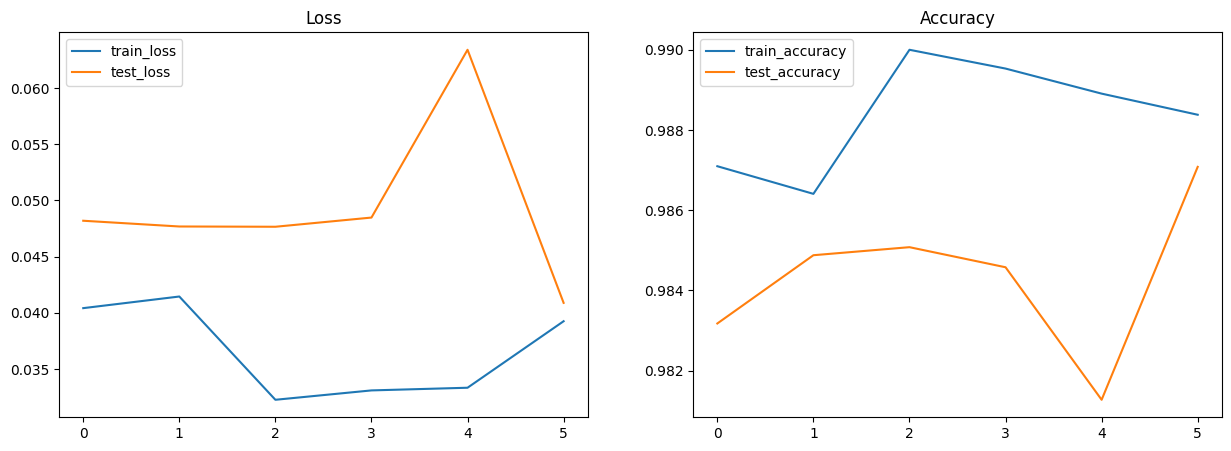

In [8]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

    clear_output(wait=True)
    # Plot loss and accuracy in subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')
    for dataset in ('train', 'test'):
      ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
      ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
    ax1.legend()
    ax2.legend()
    plt.show()

## 7. Perform inference on the test set

Create a `jit`-compiled model inference function (with `nnx.jit`) - `pred_step` - to generate predictions on the test set using the learned model parameters. This will enable you to visualize test images alongside their predicted labels for a qualitative assessment of model performance.

In [ ]:
model.eval() # Switch to evaluation mode.

@nnx.jit
def pred_step(model: CNN, batch):
  logits = model(batch['image'])
  return logits.argmax(axis=1)

Note that we use `.eval()` to ensure that the model is in evaluation mode, even though we are not using `Dropout` or `BatchNorm` in this model, `.eval()` ensure that the outputs are deterministic.

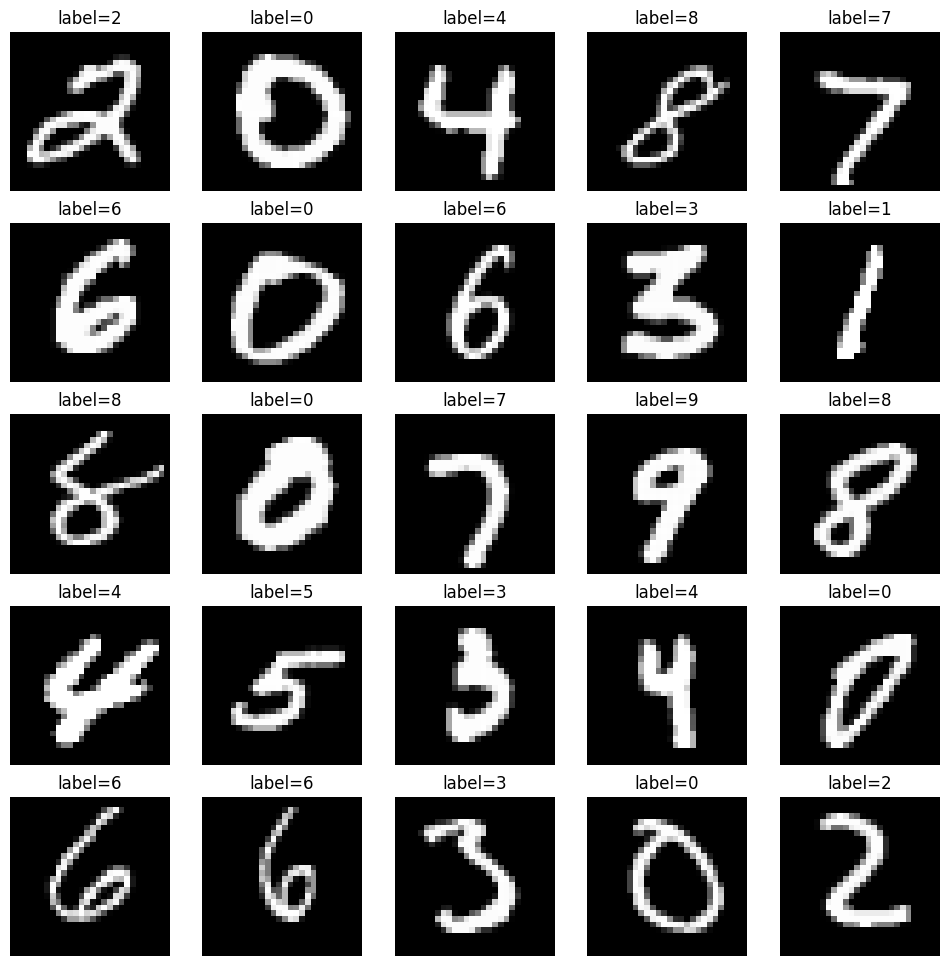

In [ ]:
test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(model, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
  ax.set_title(f'label={pred[i]}')
  ax.axis('off')

Congratulations! You have learned how to use Flax NNX to build and train a simple classification model end-to-end on the MNIST dataset.

Next, check out [Why Flax NNX?](https://flax.readthedocs.io/en/latest/why.html) and get started with a series of [Flax NNX Guides](https://flax.readthedocs.io/en/latest/guides/index.html).